# Libraries

In [48]:
import requests

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib


pd.set_option('display.max_columns', None) # display all columns in DF

# Import data

In [49]:
df = pd.read_csv('output_regression_org.csv', sep = '~')
df

,date,unique_id,generic_units_reimbursed_sum,generic_total_amount_reimbursed_adj_sum,units_reimbursed_sum,total_amount_reimbursed_adj_sum,col_temp,running_count_generics,number_of_first_entrance,running_count_from_fourth_entrance,running_count_from_third_entrance,running_count_from_second_entrance,running_count_from_start,first_nda,labeler_name,labeler_name_count,marketing_category,brand_name,generic_name,pharm_class,is_original_packager,units_reimbursed,total_amount_reimbursed_adj,price_per_unit_adj,unique_substitute,running_count_unique_substitute,running_count_event,generic_share_units_reimbursed_sum,generic_share_total_amount_reimbursed_adj_sum
0,1991-01-01,acetohydroxamic acid-tablet-oral-250 mg/1,0.0,0.0,18592.0,50898.137194,1.0,0,1.0,0.0,0.0,0.0,1.0,1.0,Mission Pharmacal Company,1,NDA,Lithostat,ACETOHYDROXAMIC ACID,"['Urease Inhibitor [EPC]', 'Urease Inhibitors ...",True,18592.0,50898.137194,2.737636,Urease Inhibitor [EPC]-ORAL-Urease Inhibitors ...,0.0,NaN,0.0,0.0
1,1991-04-01,acetohydroxamic acid-tablet-oral-250 mg/1,0.0,0.0,18839.0,51893.063430,2.0,0,1.0,0.0,0.0,0.0,2.0,1.0,Mission Pharmacal Company,1,NDA,Lithostat,ACETOHYDROXAMIC ACID,"['Urease Inhibitor [EPC]', 'Urease Inhibitors ...",True,18839.0,51893.063430,2.754555,Urease Inhibitor [EPC]-ORAL-Urease Inhibitors ...,0.0,NaN,0.0,0.0
2,1991-07-01,acetohydroxamic acid-tablet-oral-250 mg/1,0.0,0.0,28418.0,76648.158195,3.0,0,1.0,0.0,0.0,0.0,3.0,1.0,Mission Pharmacal Company,1,NDA,Lithostat,ACETOHYDROXAMIC ACID,"['Urease Inhibitor [EPC]', 'Urease Inhibitors ...",True,28418.0,76648.158195,2.697169,Urease Inhibitor [EPC]-ORAL-Urease Inhibitors ...,0.0,NaN,0.0,0.0
3,1991-10-01,acetohydroxamic acid-tablet-oral-250 mg/1,0.0,0.0,34263.0,88082.844442,4.0,0,1.0,0.0,0.0,0.0,4.0,1.0,Mission Pharmacal Company,1,NDA,Lithostat,ACETOHYDROXAMIC ACID,"['Urease Inhibitor [EPC]', 'Urease Inhibitors ...",True,34263.0,88082.844442,2.570786,Urease Inhibitor [EPC]-ORAL-Urease Inhibitors ...,0.0,NaN,0.0,0.0
4,1992-01-01,acetohydroxamic acid-tablet-oral-250 mg/1,0.0,0.0,32343.0,80168.781465,5.0,0,1.0,0.0,0.0,0.0,5.0,1.0,Mission Pharmacal Company,1,NDA,Lithostat,ACETOHYDROXAMIC ACID,"['Urease Inhibitor [EPC]', 'Urease Inhibitors ...",True,32343.0,80168.781465,2.478706,Urease Inhibitor [EPC]-ORAL-Urease Inhibitors ...,0.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225130,2021-01-01,"relugolix-tablet, film coated-oral-120 mg/1",0.0,0.0,334.0,25178.148429,1.0,0,1.0,0.0,0.0,0.0,1.0,1.0,"Myovant Sciences, Inc.",1,NDA,Orgovyx,RELUGOLIX,['Breast Cancer Resistance Protein Inhibitors ...,True,334.0,25178.148429,75.383678,Gonadotropin Releasing Hormone Receptor Antago...,0.0,NaN,0.0,0.0
225131,2021-01-01,sodium sulfate-tablet-oral-17.75 g/1,0.0,0.0,18482.0,116215.796805,1.0,0,1.0,0.0,0.0,0.0,1.0,1.0,"Braintree Laboratories, Inc.",1,NDA,SUTAB,SODIUM SULFATE,"['Calculi Dissolution Agent [EPC]', 'Increased...",True,18482.0,116215.796805,6.288053,Calculi Dissolution Agent [EPC]-ORAL-Magnesium...,5.0,NaN,0.0,0.0
225132,2021-01-01,tetracaine-cream-topical-70 mg/g,0.0,0.0,22080.0,182983.910562,1.0,0,1.0,0.0,0.0,0.0,1.0,1.0,"Taro Pharmaceuticals U.S.A., Inc.",1,NDA,PLIAGLIS,TETRACAINE,"['Amide Local Anesthetic [EPC]', 'Amides [CS]'...",True,22080.0,182983.910562,8.287315,Amide Local Anesthetic [EPC]-TOPICAL-nan,2.0,NaN,0.0,0.0
225133,2021-01-01,"vancomycin-injection, solution-intravenous-750...",0.0,0.0,40504.0,6065.081356,1.0,0,1.0,0.0,0.0,0.0,1.0,1.0,Xellia Pharmaceuticals USA LLC,1,NDA,Vancomycin,VANCOMYCIN,"['Glycopeptide Antibacterial [EPC]', 'Glycopep...",True,40504.0,6065.081356,0.149740,Glycopeptide Antibacterial [EPC]-INTRAVENOUS-nan,10.0,NaN,0.0,0.0


# Number of producer versus price per. unit

In [50]:
df_figure_1 = df.groupby("labeler_name_count")["price_per_unit_adj"].mean()
df_figure_1 = pd.DataFrame(df_figure_1.reset_index())
#df_figure_1

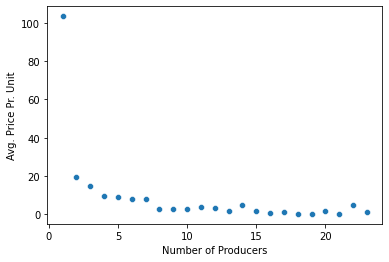

In [51]:
Intro_fig = sns.scatterplot(x="labeler_name_count", y="price_per_unit_adj", data=df_figure_1)
Intro_fig.set(xlabel = "Number of Producers", ylabel = "Avg. Price Pr. Unit")
Intro_fig = Intro_fig.get_figure()
Intro_fig.savefig("Avg_price_and_number_of_producers.png")

# Specific drug figure

In [52]:
df_figure = df.loc[df['unique_id'] == 'alprazolam-tablet-oral-.5 mg/1']
df_figure['date'] = pd.to_datetime(df_figure['date'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors='coerce')

C:\Users\Louis\AppData\Local\Temp/ipykernel_29840/757018050.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_figure['date'] = pd.to_datetime(df_figure['date'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors='coerce')
C:\Users\Louis\AppData\Local\Temp/ipykernel_29840/757018050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_figure['date'] = pd.to_datetime(df_figure['date'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors='coerce')


In [53]:
df_figure = df_figure.groupby(['date', 'generic_name', 'labeler_name'])['price_per_unit_adj'].mean()
df_figure = df_figure.reset_index()
df_figure['ln_price_per_unit_adj'] = np.log(df_figure['price_per_unit_adj'])

In [54]:
df_figure

,date,generic_name,labeler_name,price_per_unit_adj,ln_price_per_unit_adj
0,1991-01-01,ALPRAZOLAM,Pharmacia & Upjohn Company LLC,2.122635,0.752658
1,1991-04-01,ALPRAZOLAM,Pharmacia & Upjohn Company LLC,2.233509,0.803574
2,1991-07-01,ALPRAZOLAM,Pharmacia & Upjohn Company LLC,2.123210,0.752929
3,1991-10-01,ALPRAZOLAM,Pharmacia & Upjohn Company LLC,2.170762,0.775078
4,1992-01-01,ALPRAZOLAM,Pharmacia & Upjohn Company LLC,2.185910,0.782032
...,...,...,...,...,...
506,2021-01-01,ALPRAZOLAM,"Breckenridge Pharmaceutical, Inc.",0.114706,-2.165384
507,2021-01-01,ALPRAZOLAM,Greenstone LLC,0.136088,-1.994455
508,2021-01-01,ALPRAZOLAM,Par Pharmaceutical,0.130488,-2.036475
509,2021-01-01,ALPRAZOLAM,Pharmacia & Upjohn Company LLC,5.150481,1.639090


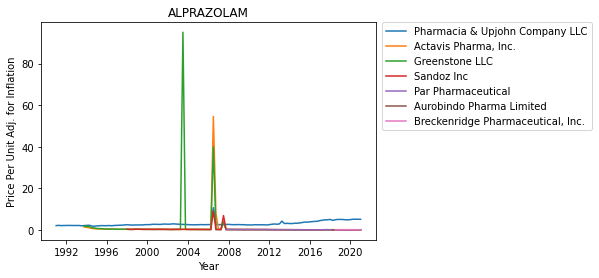

In [55]:
p = sns.lineplot(data = df_figure, x = 'date', y = 'price_per_unit_adj', hue = 'labeler_name', ci = 0)
plt.legend(bbox_to_anchor = (1.02, 1), loc = 'upper left', borderaxespad = 0)
p.set(xlabel = 'Year', ylabel = 'Price Per Unit Adj. for Inflation', title = df_figure['generic_name'][0])
p = p.get_figure()
p.savefig("Drug_fig.png",bbox_inches="tight")

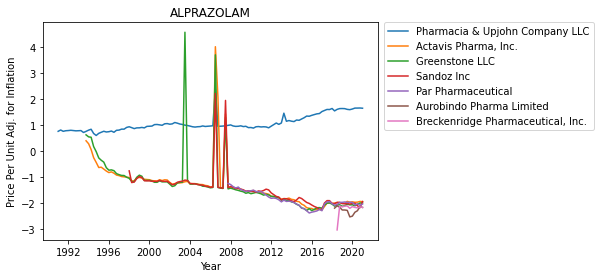

In [56]:
p = sns.lineplot(data = df_figure, x = 'date', y = 'ln_price_per_unit_adj', hue = 'labeler_name', ci = 0)
plt.legend(bbox_to_anchor = (1.02, 1), loc = 'upper left', borderaxespad = 0)
p.set(xlabel = 'Year', ylabel = 'Price Per Unit Adj. for Inflation', title = df_figure['generic_name'][0])
p = p.get_figure()
p.savefig("Drug_fig_ln.png", bbox_inches="tight")

In [57]:
df_figure.to_excel('output_for_one_drug.xlsx', index = False)

# Event figure - average

In [71]:
df_fig_event = df.dropna()
df_fig_event = df_fig_event.reset_index(drop=True)
df_fig_event = df_fig_event.groupby('running_count_event')['price_per_unit_adj'].mean()
df_fig_event = df_fig_event.reset_index()

No handles with labels found to put in legend.


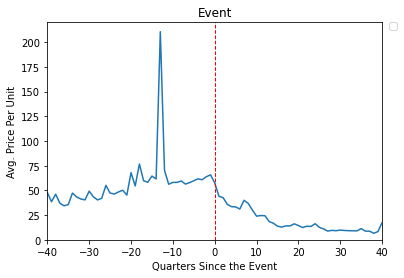

In [80]:
p_event = sns.lineplot(data = df_fig_event, x = 'running_count_event', y = 'price_per_unit_adj')
plt.legend(bbox_to_anchor = (1.02, 1), loc = 'upper left', borderaxespad = 0)
p_event.set(xlabel = 'Quarters Since the Event', ylabel = 'Avg. Price Per Unit', title ='Event')
plt.axvline(0, color = "red", lw = 1, ls='--')
plt.xlim([-40, 40])
plt.ylim([0, 220])
p_event = p_event.get_figure()
p_event.savefig("Fig_event.png", bbox_inches="tight")

# Event figure - average - log

In [65]:
df_figure

,date,generic_name,labeler_name,price_per_unit_adj,ln_price_per_unit_adj
0,1991-01-01,ALPRAZOLAM,Pharmacia & Upjohn Company LLC,2.122635,0.752658
1,1991-04-01,ALPRAZOLAM,Pharmacia & Upjohn Company LLC,2.233509,0.803574
2,1991-07-01,ALPRAZOLAM,Pharmacia & Upjohn Company LLC,2.123210,0.752929
3,1991-10-01,ALPRAZOLAM,Pharmacia & Upjohn Company LLC,2.170762,0.775078
4,1992-01-01,ALPRAZOLAM,Pharmacia & Upjohn Company LLC,2.185910,0.782032
...,...,...,...,...,...
506,2021-01-01,ALPRAZOLAM,"Breckenridge Pharmaceutical, Inc.",0.114706,-2.165384
507,2021-01-01,ALPRAZOLAM,Greenstone LLC,0.136088,-1.994455
508,2021-01-01,ALPRAZOLAM,Par Pharmaceutical,0.130488,-2.036475
509,2021-01-01,ALPRAZOLAM,Pharmacia & Upjohn Company LLC,5.150481,1.639090


In [73]:
df_fig_event_2 = df.dropna()
df_fig_event_2 = df_fig_event_2.reset_index(drop=True)
df_fig_event_2['ln_price_per_unit_adj'] = np.log(df_fig_event_2['price_per_unit_adj'])
df_fig_event_2 = df_fig_event_2.groupby('running_count_event')['ln_price_per_unit_adj'].mean()
df_fig_event_2 = df_fig_event_2.reset_index()

No handles with labels found to put in legend.


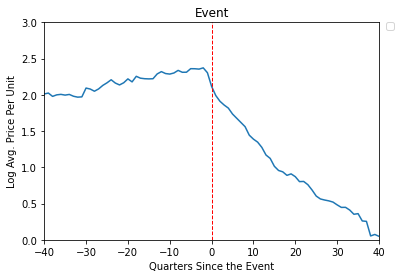

In [78]:
p_event = sns.lineplot(data = df_fig_event_2, x = 'running_count_event', y = 'ln_price_per_unit_adj')
plt.legend(bbox_to_anchor = (1.02, 1), loc = 'upper left', borderaxespad = 0)
p_event.set(xlabel = 'Quarters Since the Event', ylabel = 'Log Avg. Price Per Unit', title ='Event')
plt.axvline(0, color = "red", lw = 1, ls='--')
plt.xlim([-40, 40])
plt.ylim([0, 3])
p_event = p_event.get_figure()
p_event.savefig("Fig_event.png", bbox_inches="tight")